# GDP to monthly transformation. Exploring options

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.interp.denton as denton
from tempdisagg import TempDisaggModel
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

First of all, let's load up the YoY growth rates and explain what's going on.

In [2]:
yoy_growth_rates = pd.read_excel('../data/preliminary_data/georgia_monthly_yoy_growth_rates_2011_2024.xlsx')
yoy_growth_rates.head()


,Date,YoY Growth (%)
0,2011-01-01,9.6
1,2011-02-01,4.4
2,2011-03-01,3.7
3,2011-04-01,6.0
4,2011-05-01,1.7


The National Statistics Office of Georgia has been publishing Year-over-Year (YoY) growth rates for each month since 2011. Consequently, data prior to this year is unavailable.

The YoY growth rates are calculated as the percentage change in Gross Domestic Product (GDP) compared to the same month in the preceding year. These rates are disseminated by GeoStat as a measure of economic performance, and for example, the YoY growth rate for March 2011 is the percentage change in GDP compared to March 2010.

GeoStat employs administrative data, including Value Added Tax (VAT) taxpayers' turnover, along with fiscal and monetary statistics, to produce rapid monthly estimations of real GDP growth. This practice aligns with international standards for obtaining preliminary monthly growth figures of real GDP. In sectors lacking preliminary monthly data, such as agriculture and the non-observed economy, estimations rely on historical data. As a result, actual quarterly real GDP growth may diverge significantly from these rapid monthly estimates.

Additionally, the data concerning VAT taxpayers' turnover may be revised monthly, necessitating corresponding adjustments to the real GDP growth estimates.
 
The variation in YoY growth rates is characterized by volatility rather than linearity, necessitating the application of more sophisticated modeling techniques to accurately fit the data.

We will now proceed to plot the YoY growth rates.



In [3]:
def plot_time_series_with_inset(data, x_col, y_cols, 
                               inset_start_date=None,
                               highlight_period=None,
                               figsize=(12,6), dpi=600):
    """
    Plot a time series with an inset zoom and optional period highlighting.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the time series data
    x_col : str
        Column name for x-axis (dates)
    y_cols : str or list
        Column name(s) for y-axis (values)
    inset_start_date : str, optional
        Start date for inset zoom (format: 'YYYY-MM-DD')
    highlight_period : tuple, optional
        (start_date, end_date) to highlight (format: 'YYYY-MM-DD')
    figsize : tuple, optional
        Figure size (width, height)
    dpi : int, optional
        Figure resolution
    """
    sns.set_palette("deep")
    sns.set_style("whitegrid")
    
    # Convert y_cols to list if string
    if isinstance(y_cols, str):
        y_cols = [y_cols]
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Main line plots
    for y_col in y_cols:
        sns.lineplot(data=data, x=x_col, y=y_col, ax=ax, label=y_col)
    
    if highlight_period:
        start_date, end_date = highlight_period
        # Use the first y_col for highlighting to avoid duplicate legend entries
        highlight_col = y_cols[0]
        ax.fill_between(
            data[x_col],
            data[highlight_col],
            where=(data[x_col].between(start_date, end_date)),
            color='red', alpha=0.3, label='Covid Period'
        )
    
    # Center horizontal axis at zero
    ax.axhline(0, color='black', linewidth=1)
    
    # Only horizontal grid lines
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.grid(axis='x', visible=False)
    
    ax.set_title(f'Monthly Growth Rates (2011-2024)')
    ax.set_xlabel(x_col)
    ax.set_ylabel('Growth Rate (%)')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.legend()
    
    if inset_start_date:
        ax_inset = inset_axes(
            ax, width="60%", height="60%", loc='upper left',
            bbox_to_anchor=(0.04, 0.35, 0.6, 0.6), bbox_transform=ax.transAxes
        )
        subset = data[data[x_col] >= inset_start_date]
        for y_col in y_cols:
            sns.lineplot(data=subset, x=x_col, y=y_col, ax=ax_inset, label=y_col)
        ax_inset.set_title(f'Zoom: {inset_start_date[:4]}-present', fontsize=10)
        ax_inset.axhline(0, color='black', linewidth=1)
        ax_inset.set_xlabel('')
        plt.setp(ax_inset.get_xticklabels(), rotation=45)
        
        # Only horizontal grid lines for inset
        ax_inset.grid(axis='y', linestyle='--', linewidth=0.5)
        ax_inset.grid(axis='x', visible=False)
        # disable legend for inset
        ax_inset.legend().set_visible(False)
        
        # Connect inset to main plot
        mark_inset(ax, ax_inset, loc1=2, loc2=1, fc="none", ec="gray", linewidth=0.5)
    
    plt.tight_layout()
    # Save the plot first before showing
    plt.savefig(f'../images/{y_col}_plot.png', dpi=600, bbox_inches='tight')
    plt.savefig(f'../images/{y_col}_plot.svg', bbox_inches='tight')
    plt.show()


/var/folders/50/97r9rj4j6s9f_0_j75x32sxr0000gn/T/ipykernel_74049/3403268761.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


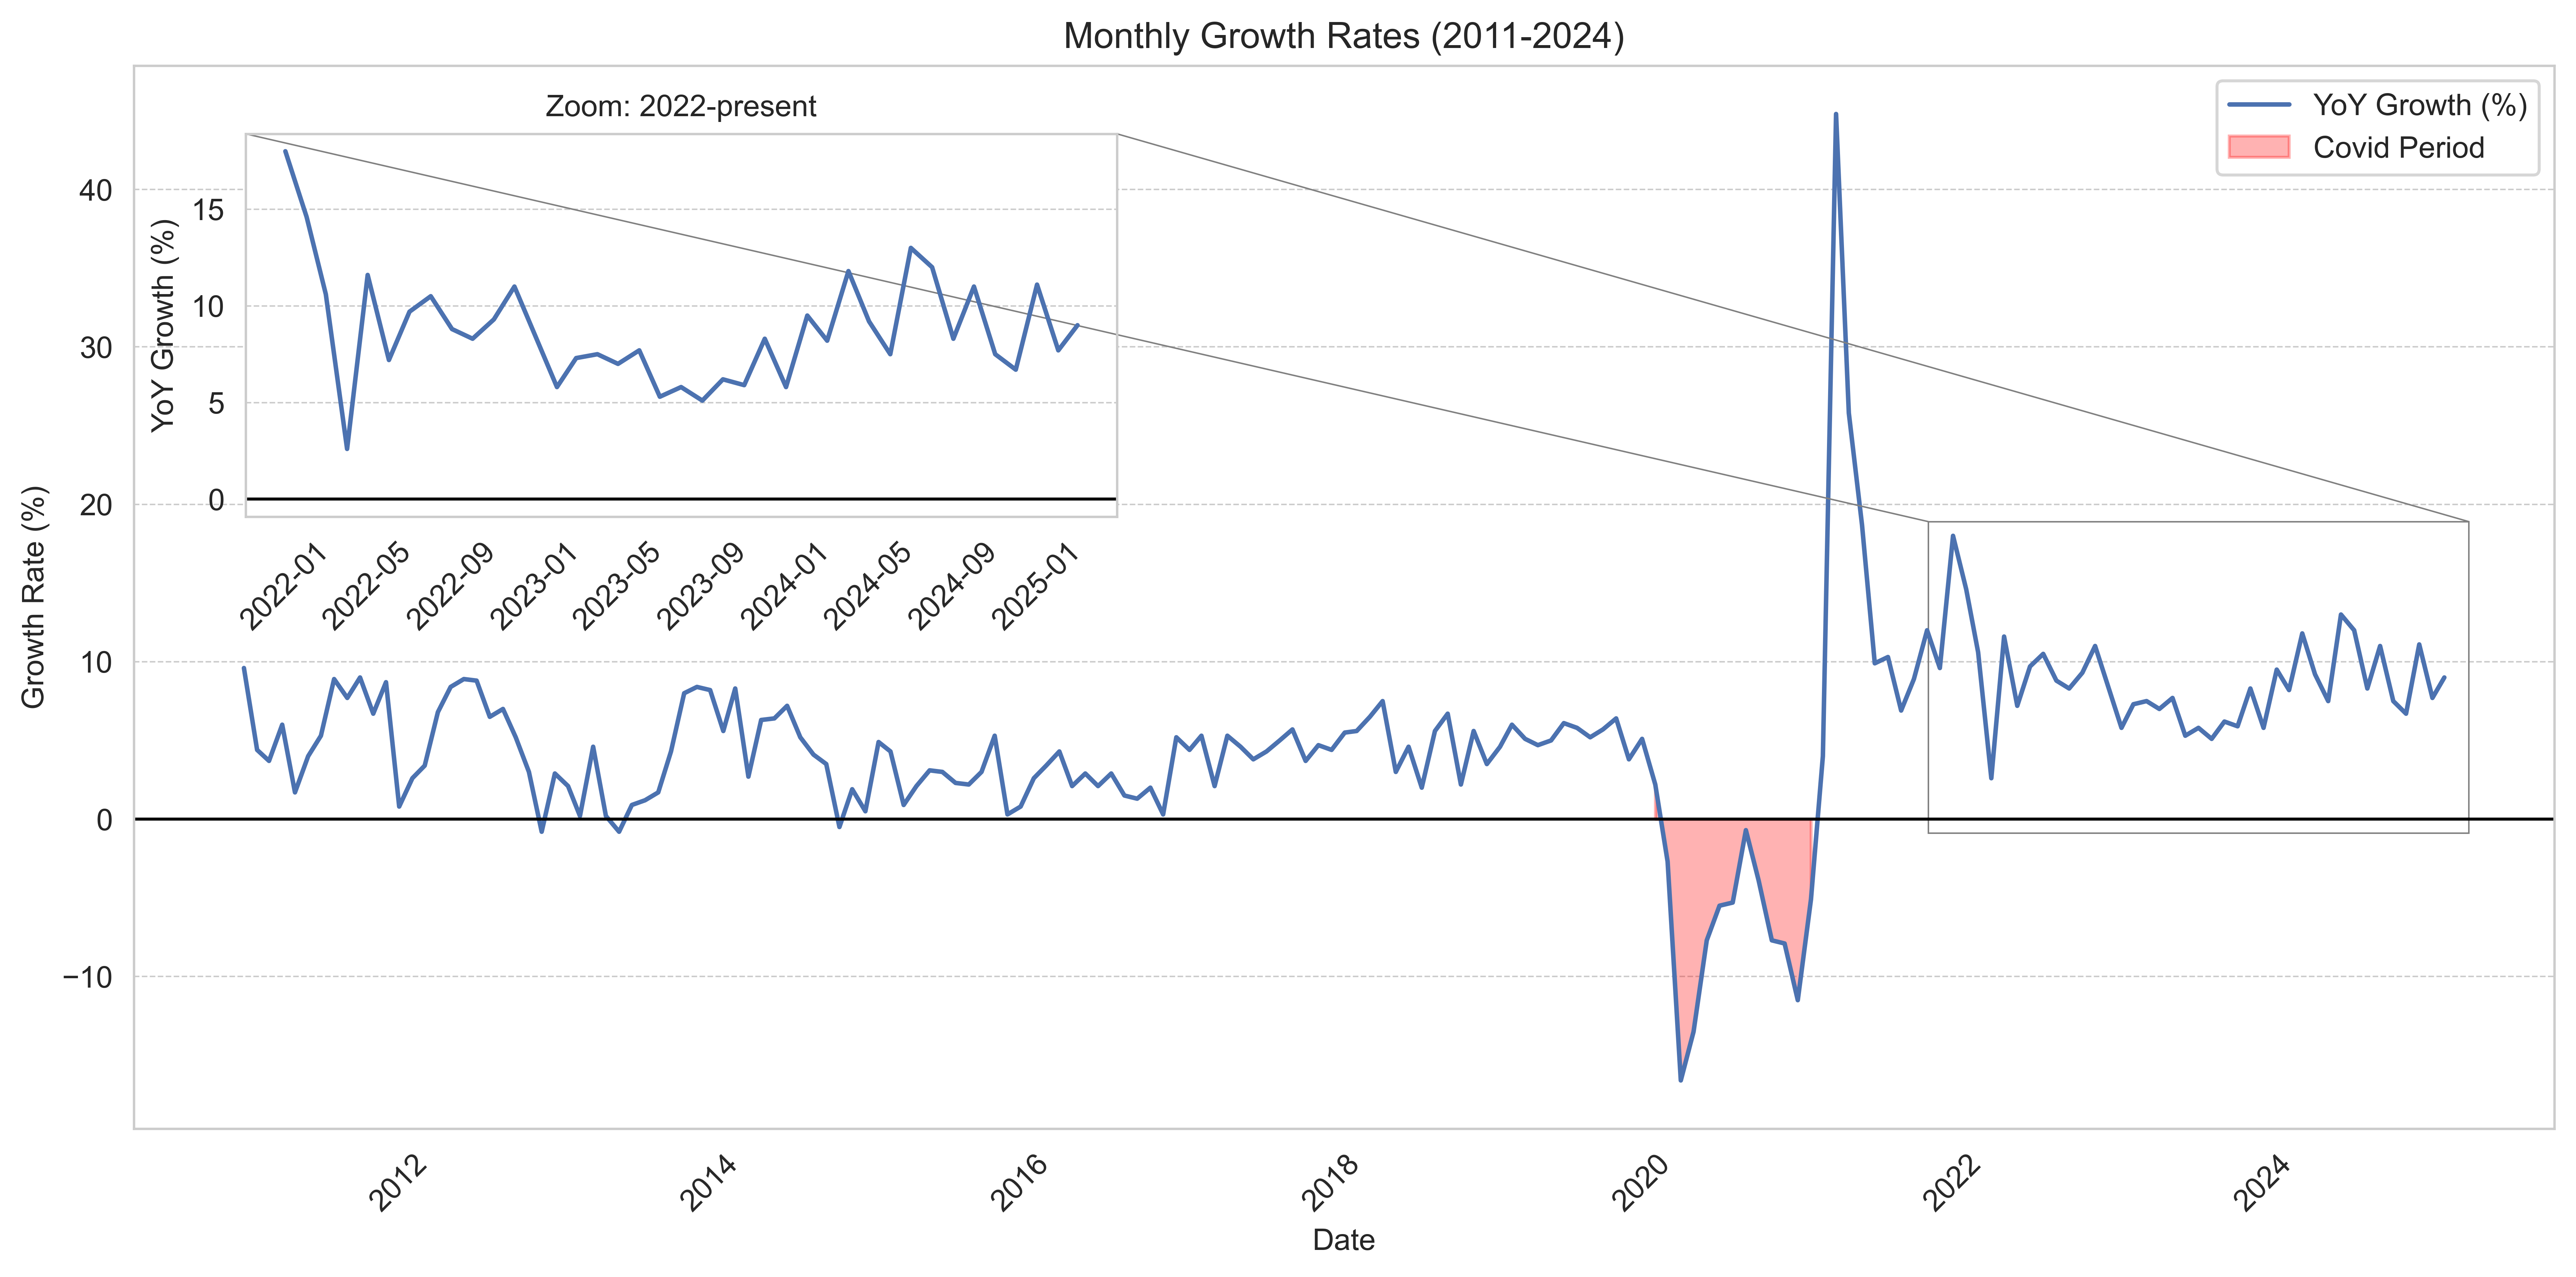

In [4]:
plot_time_series_with_inset(
    data=yoy_growth_rates,
    x_col='Date',
    y_cols='YoY Growth (%)',
    inset_start_date='2022-01-01',
    highlight_period=('2020-02-01', '2021-02-01')
)

The analysis of year-over-year (YoY) growth rates reveals significant volatility in the Georgian economy, characterized by non-linear patterns with frequent fluctuations rather than steady progression. Despite these oscillations, the economy has generally maintained positive growth trajectories, albeit with periodic deceleration.

The year 2020 represents a notable exception, during which growth rates turned negative, a direct consequence of the COVID-19 pandemic, as highlighted in the visualization.

From 2022 onward, the Georgian economy exhibited remarkable resilience, consistently maintaining growth rates above 5%. This stands in stark contrast to the previous decade, which witnessed occasional periods of stagnation or contraction. This robust performance can be attributed to geopolitical developments, specifically the Russo-Ukrainian conflict, which precipitated significant supply chain reconfigurations. Consequently, Georgia emerged as a strategic transit corridor facilitating trade flows between Europe and Asia, thereby stimulating economic expansion.

Looking at growth data isn't enough to get the full picture, we need to see inflation data as well. The relationship between real GDP growth, nominal GDP growth, and inflation can be expressed through the following formula:

$$ \text{Real GDP Growth} = \frac{1 + \text{Nominal GDP Growth}}{1 + \text{Inflation Rate}} - 1 $$



In [5]:
# Let's load up the inflation data and see how it looks.
# Data is already in percentages, so we don't need to divide by 100.
inflation_data = pd.read_excel('../data/preliminary_data/georgia_monthly_inflation_2004_2025.xlsx')
# keep in date firts days of the month
inflation_data['Date'] = pd.to_datetime(inflation_data['Date'])
inflation_data['Date'] = inflation_data['Date'].dt.to_period('M').apply(lambda x: x.start_time)
inflation_data.head()
# We will look at Total_CPI

,Date,Total_CPI,Food and non-alcoholic beverages_CPI,Alcoholic beverages and tobacco_CPI,Clothing and footwear_CPI,"Housing, water, electricity, gas and other fuels_CPI","Furnishings, household equipment and routine maintenance of the house_CPI",Health_CPI,Transport_CPI,Communication_CPI,Recreation and culture_CPI,Education_CPI,Restaurants and hotels_CPI,Miscellaneous goods and services_CPI
0,2025-04-01,0.1658,0.4440,-0.1892,1.5021,-0.0392,-0.6947,0.4159,-1.0252,-0.1423,-0.0349,-0.0287,0.7352,0.5999
1,2025-03-01,1.0717,2.7722,-0.3496,0.9810,-0.1110,-0.3490,1.7157,-0.1588,-0.1619,0.1260,-0.2026,0.7178,0.2252
2,2025-02-01,0.4042,0.6888,0.5403,-2.7590,-0.0310,0.5259,2.3187,0.3298,0.1421,-0.5555,-0.0078,1.1168,0.6400
3,2025-01-01,0.4159,1.1474,0.9510,-2.6296,0.0021,-0.8153,1.1368,-0.1449,0.1166,0.4477,0.0005,-0.2994,0.7845
4,2024-12-01,0.6831,1.3369,0.4078,-1.8234,0.3032,0.7083,1.4345,0.5421,0.2553,-0.3598,0.1337,0.3344,-0.2908


In [6]:
# First, ensure dates are in the same format
inflation_data['Date'] = pd.to_datetime(inflation_data['Date'])
yoy_growth_rates['Date'] = pd.to_datetime(yoy_growth_rates['Date'])

# Select only the Total_CPI column from inflation data for merging
inflation_subset = inflation_data[['Date', 'Total_CPI']].rename(columns={'Total_CPI': 'Inflation_Rate'})

merged_data = pd.merge(yoy_growth_rates, inflation_subset, on='Date', how='left')

# Calculate nominal GDP growth using the formula: (1 + real growth) * (1 + inflation) - 1
merged_data['Real_GDP_Growth'] = (
    (1 + merged_data['YoY Growth (%)']/100)
    / (1 + merged_data['Inflation_Rate']/100)
    - 1
) * 100

inflation_data = merged_data.copy()
# Display the merged data
merged_data.head()

,Date,YoY Growth (%),Inflation_Rate,Real_GDP_Growth
0,2011-01-01,9.6,2.0537,7.394440
1,2011-02-01,4.4,2.8186,1.538049
2,2011-03-01,3.7,-0.0218,3.722612
3,2011-04-01,6.0,-0.1427,6.151478
4,2011-05-01,1.7,0.3750,1.320050


/var/folders/50/97r9rj4j6s9f_0_j75x32sxr0000gn/T/ipykernel_74049/3403268761.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


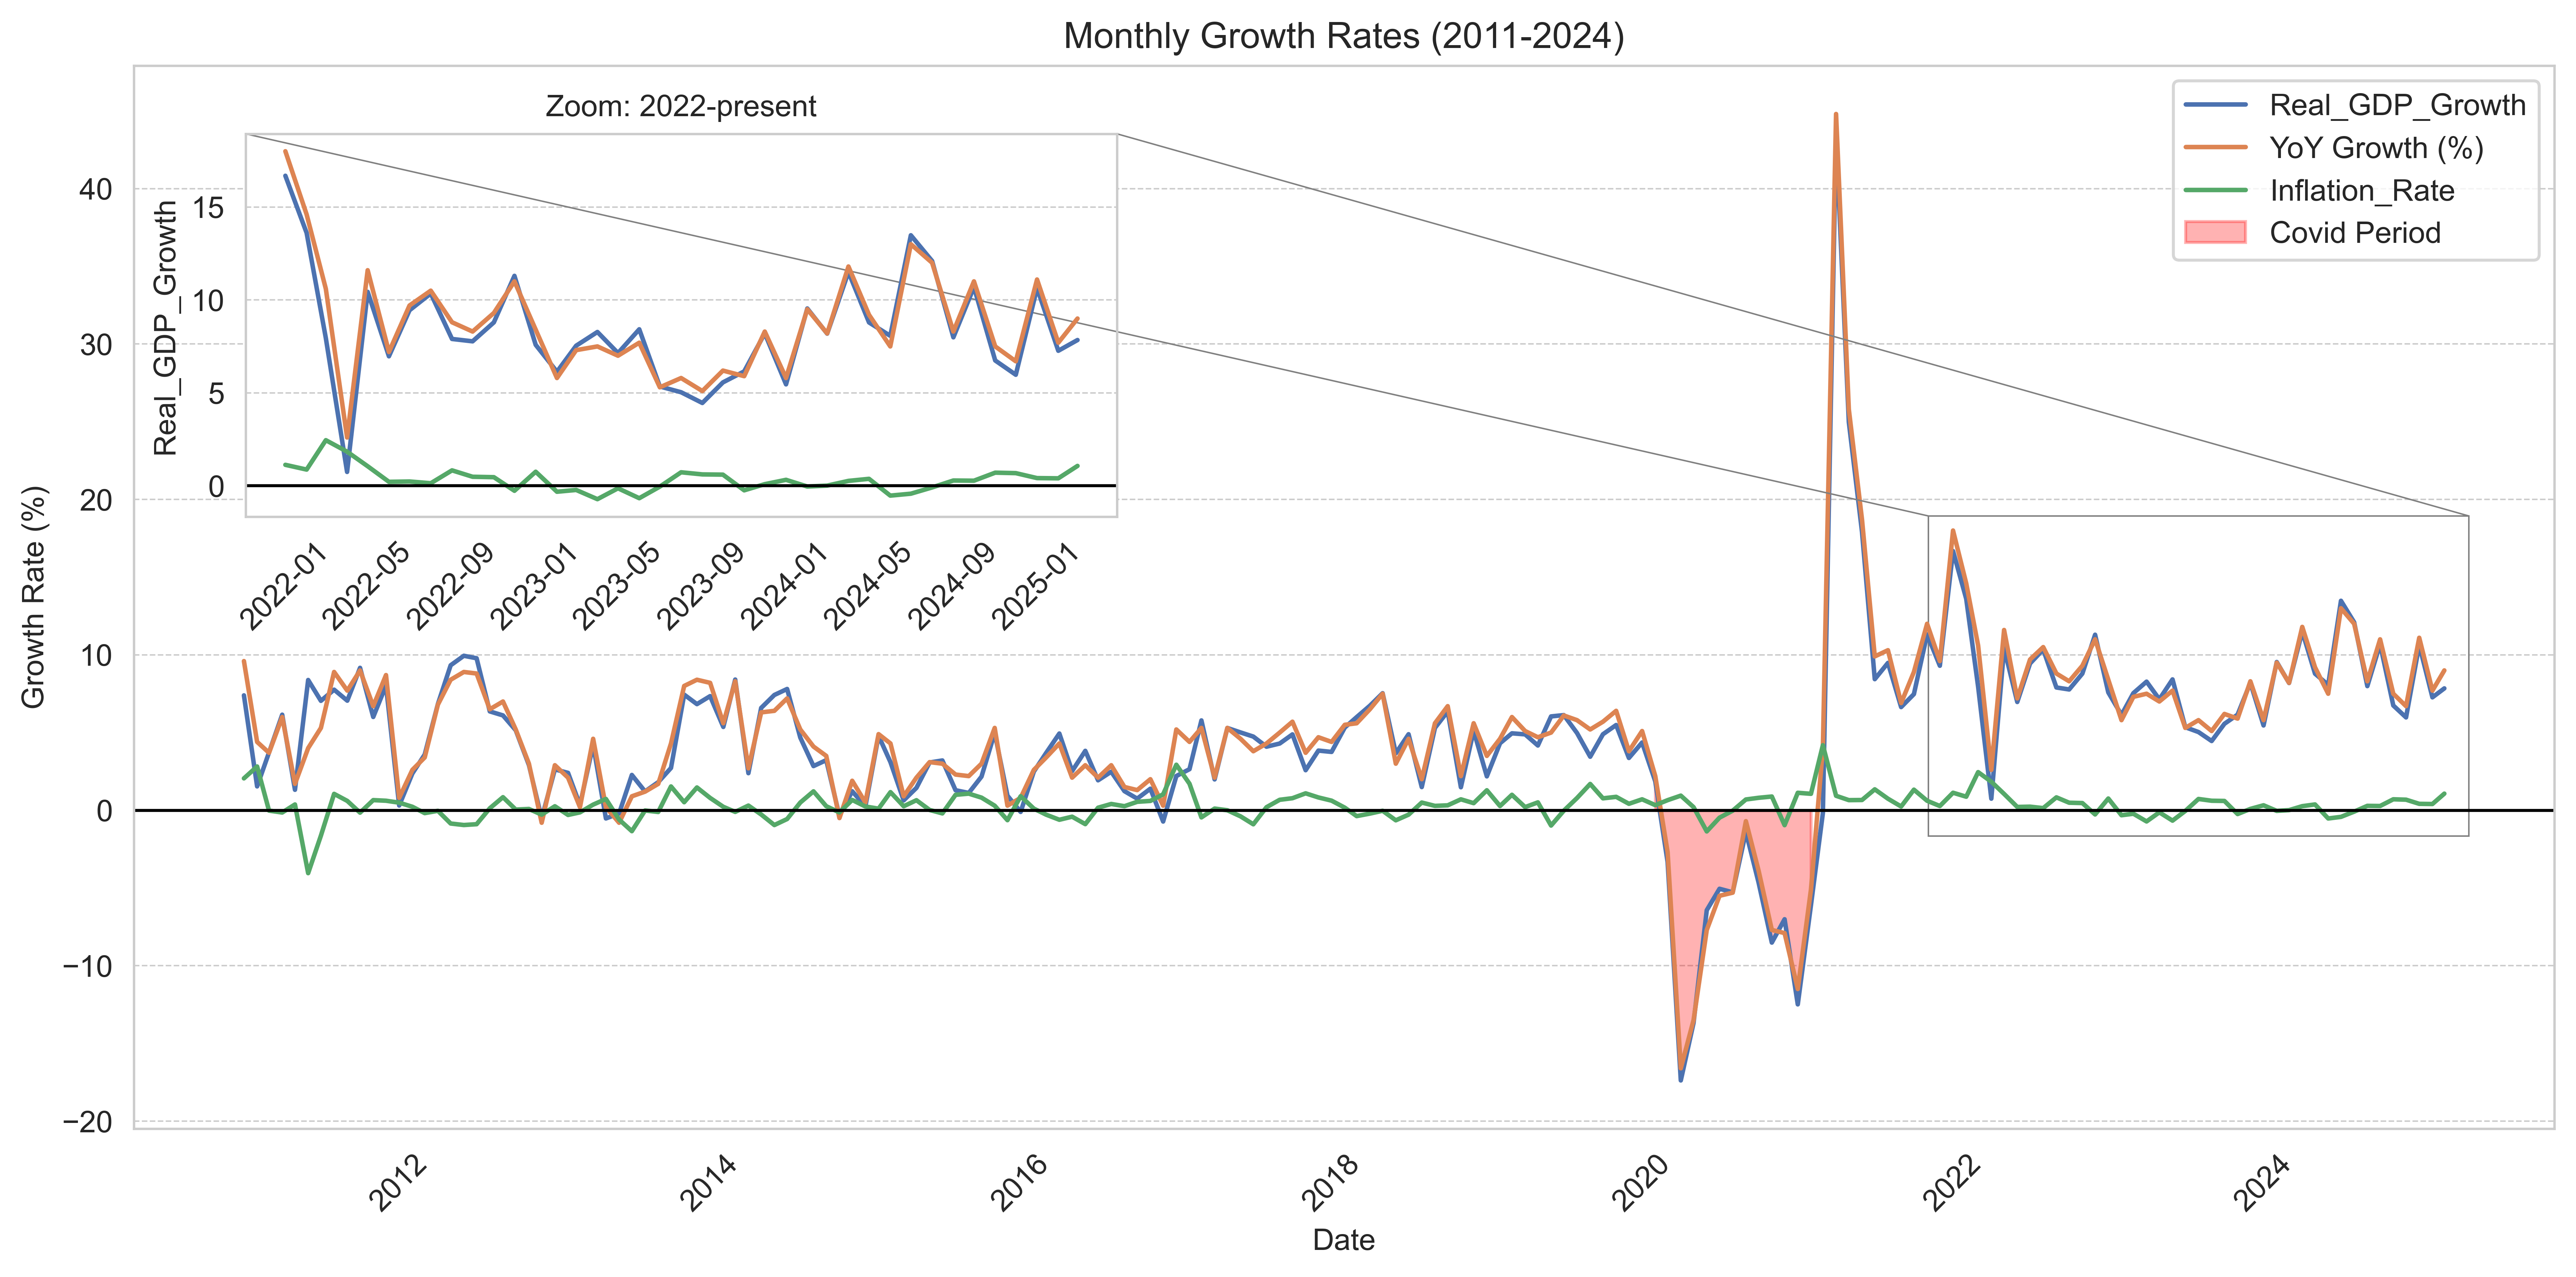

In [7]:
plot_time_series_with_inset(
    data=merged_data,
    x_col='Date',
    y_cols=['Real_GDP_Growth', 'YoY Growth (%)', 'Inflation_Rate'],
    inset_start_date='2022-01-01',
    highlight_period=('2020-02-01', '2021-02-01')
)

## Key Highlights from the Analysis of Monthly Growth Rates (2011–2024)

- **Volatility in Economic Growth:**  
  The Georgian economy exhibited significant volatility in both real GDP growth and year-over-year (YoY) growth rates throughout the period. These fluctuations underscore the non-linear and dynamic nature of economic activity in the country.

- **Impact of the COVID-19 Pandemic:**  
  The period from February 2020 to February 2021 is marked by a pronounced contraction in economic growth, as evidenced by the sharp decline in both real GDP and YoY growth rates. This downturn coincides with the onset of the COVID-19 pandemic and its associated economic disruptions.

- **Post-Pandemic Recovery and Resilience:**  
  Following the pandemic-induced recession, the Georgian economy demonstrated a robust recovery. From 2022 onwards, both real GDP growth and YoY growth rates remained consistently positive, frequently exceeding 5%. This sustained growth is likely attributable to favorable geopolitical developments and Georgia’s strategic role as a transit corridor.

- **Inflation Dynamics:**  
  Inflation rates remained relatively subdued and stable over the entire period, with no significant spikes even during periods of economic turbulence. This suggests effective monetary policy and price stability despite external shocks.

- **Alignment of Growth Measures:**  
  The close correspondence between real GDP growth and YoY growth rates, as depicted in the plot, reflects the underlying relationship between these indicators and the relatively minor influence of inflation during the observed period.

In [8]:
inflation_data.to_csv('../data/processed_data/georgia_monthly_growth_and_inflation_2011_2024.csv', index=False)

## Proportional Denton, Quarterly data to Monthly

The Proportional Denton method is a temporal disaggregation technique available in statsmodels.tsa.interp.denton module.
This method allows us to convert low-frequency data (like quarterly GDP) into higher-frequency estimates (monthly)
while preserving the temporal movement of a related high-frequency indicator series. The method works by 
minimizing the following objective function:

$$\min_{\{x_t\}} \sum_{t=2}^{n} \left(\frac{x_t}{x_{t-1}} - \frac{i_t}{i_{t-1}}\right)^2$$

subject to the constraint:

$$\sum_{t \in j} x_t = z_j \quad \forall j$$

where:
- $x_t$ is the target high-frequency series (monthly GDP)
- $i_t$ is the related indicator series (monthly)
- $z_j$ is the low-frequency benchmark series (quarterly GDP)
- $j$ indexes the periods in the low-frequency series

This approach ensures that:
1. The temporal pattern of the indicator series is preserved
2. The sum of monthly estimates within each quarter equals the quarterly total
3. The resulting monthly series maintains economic coherence with both the indicator and benchmark series

In [9]:
# read in the quarterly GDP data
quarterly_gdp = pd.read_excel('../data/processed_data/georgia_quarterly_gdp_processed.xlsx')
quarterly_gdp.head()


,Date,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, steam and air conditioning supply","Water supply; sewerage, waste management and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,...,(=) GDP at basic prices,(+) Taxes on products,(-) Subsidies on products,(=) GDP at market prices,GDP per capita in GEL,"GDP per capita, USD",GDP in mil. USD,"Exchange rate, USD/GEL, average of the same period",Unnamed: 29,"* Revised data will be published on November 14, 2025."
0,I 10,383.120948,31.174114,400.160940,139.246213,43.245285,108.278327,641.313261,299.091084,63.505837,...,4099.777540,516.939744,25.659811,4591.057474,1212.418078,704.392784,2667.320633,1.721224,NaN,NaN
1,II 10,536.382625,38.863249,484.722230,117.182112,50.541437,187.748327,747.890908,321.247281,81.888251,...,4675.545036,649.688569,28.750724,5296.482880,1398.708605,778.637100,2948.461213,1.796355,NaN,NaN
2,III 10,573.216441,41.002119,586.744968,105.803684,55.327169,231.421849,857.816571,362.784390,99.534040,...,5001.789583,741.351959,22.872155,5720.269386,1510.623218,821.664598,3111.393224,1.838491,NaN,NaN
3,IV 10,471.007383,34.488518,537.602878,151.929582,63.374406,329.430996,1056.297394,432.724667,94.594587,...,5755.753820,813.114227,28.025585,6540.842462,1727.322233,974.136687,3688.758524,1.773183,NaN,NaN
4,2010,1963.727397,145.528000,2009.231016,514.161591,212.488297,856.879499,3303.318133,1415.847422,339.522716,...,19532.865979,2721.094498,105.308275,22148.652202,5849.072133,3281.185162,12424.847447,1.782610,NaN,NaN


For the temporal disaggregation analysis, we will utilize the quarterly Gross Domestic Product (GDP) data at market prices (GEL), as well as per capita GDP denominated in both Georgian Lari (GEL) and United States Dollars (USD), along with GDP in USD. The data is structured in quarterly frequency, with period notation following the format "I 10", which denotes the first quarter of 2010 (Q1 2010). This quarterly time series will serve as our low-frequency benchmark for the Proportional Denton method implementation.

Some preliminary formatting is needed


In [10]:
# Filter out rows where 'Date' contains the year only (like '2010', '2011', etc.)
quarterly_gdp = quarterly_gdp[~quarterly_gdp['Date'].astype(str).str.match(r'^\d{4}$')]
quarterly_gdp = quarterly_gdp.iloc[:-1]
quarterly_gdp.head()

,Date,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, steam and air conditioning supply","Water supply; sewerage, waste management and remediation activities",Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,Transportation and storage,Accommodation and food service activities,...,(=) GDP at basic prices,(+) Taxes on products,(-) Subsidies on products,(=) GDP at market prices,GDP per capita in GEL,"GDP per capita, USD",GDP in mil. USD,"Exchange rate, USD/GEL, average of the same period",Unnamed: 29,"* Revised data will be published on November 14, 2025."
0,I 10,383.120948,31.174114,400.160940,139.246213,43.245285,108.278327,641.313261,299.091084,63.505837,...,4099.777540,516.939744,25.659811,4591.057474,1212.418078,704.392784,2667.320633,1.721224,NaN,NaN
1,II 10,536.382625,38.863249,484.722230,117.182112,50.541437,187.748327,747.890908,321.247281,81.888251,...,4675.545036,649.688569,28.750724,5296.482880,1398.708605,778.637100,2948.461213,1.796355,NaN,NaN
2,III 10,573.216441,41.002119,586.744968,105.803684,55.327169,231.421849,857.816571,362.784390,99.534040,...,5001.789583,741.351959,22.872155,5720.269386,1510.623218,821.664598,3111.393224,1.838491,NaN,NaN
3,IV 10,471.007383,34.488518,537.602878,151.929582,63.374406,329.430996,1056.297394,432.724667,94.594587,...,5755.753820,813.114227,28.025585,6540.842462,1727.322233,974.136687,3688.758524,1.773183,NaN,NaN
5,I 11,458.116277,40.266675,496.081075,147.702287,29.025174,116.812086,789.884402,405.994861,78.416431,...,4826.955593,631.332490,37.456040,5420.832044,1443.076775,819.517640,3078.469255,1.760886,NaN,NaN


**NOTE:** Data for 2024 is not fully available yet and will be released on November 14th, 2025.


In [11]:
# Keep only the columns we need for analysis
quarterly_gdp = quarterly_gdp[["Date", "(=) GDP at market prices", 
                              "GDP per capita in GEL", "GDP per capita, USD", "GDP in mil. USD"]]

In [12]:
quarterly_gdp.columns

Index(['Date', '(=) GDP at market prices', 'GDP per capita in GEL',
       'GDP per capita, USD', 'GDP in mil. USD'],
      dtype='object')

In [13]:
merged_data = merged_data[:-3] # removing 2025 data
quarterly_gdp = quarterly_gdp[4:] # removing 2010 data as the growth rates are not available for previous years


In [14]:
quarterly_gdp

,Date,(=) GDP at market prices,GDP per capita in GEL,"GDP per capita, USD",GDP in mil. USD
5,I 11,5420.832044,1443.076775,819.517640,3078.469255
6,II 11,6383.402398,1699.322110,1020.357974,3832.914019
7,III 11,6848.757951,1823.204161,1098.676182,4127.111707
8,IV 11,7446.382939,1982.297587,1194.287333,4486.269305
10,I 12,5968.032546,1600.492091,963.947025,3594.436517
11,II 12,6996.644662,1876.342724,1149.266328,4285.468755
12,III 12,7277.946316,1951.781501,1182.021097,4407.607145
13,IV 12,7654.231030,2052.692597,1236.023595,4608.975628
15,I 13,6084.446028,1636.629964,987.039517,3669.484735
16,II 13,7093.226014,1907.977519,1156.165980,4298.240688


In [15]:
indicator = merged_data[['YoY Growth (%)']]
benchmark = quarterly_gdp[['(=) GDP at market prices']]

benchmarked = denton.dentonm(indicator, benchmark, freq="qm")
benchmarked_df = pd.DataFrame(benchmarked, index=merged_data.index, columns=['Benchmarked_GDP'])

# merge the benchmarked data with the indicator data
merged_data = pd.concat([merged_data, benchmarked_df], axis=1)
merged_data.head()

,Date,YoY Growth (%),Inflation_Rate,Real_GDP_Growth,Benchmarked_GDP
0,2011-01-01,9.6,2.0537,7.394440,2426.740404
1,2011-02-01,4.4,2.8186,1.538049,1420.849742
2,2011-03-01,3.7,-0.0218,3.722612,1573.241897
3,2011-04-01,6.0,-0.1427,6.151478,3327.070820
4,2011-05-01,1.7,0.3750,1.320050,949.287056


In [16]:
benchmarked

array([ 2.42674040e+03,  1.42084974e+03,  1.57324190e+03,  3.32707082e+03,
        9.49287056e+02,  2.10704452e+03,  2.18097905e+03,  2.78902004e+03,
        1.87875886e+03,  1.79544046e+03,  1.83850845e+03,  3.81243403e+03,
        5.73959279e+02,  2.39616965e+03,  2.99790362e+03,  3.55479090e+03,
        2.23474850e+03,  1.20710527e+03,  1.22361171e+03,  1.96598464e+03,
        4.08834997e+03,  5.16313144e+03,  3.35592123e+03, -8.64821640e+02,
        3.15221897e+03,  2.62648600e+03,  3.05741061e+02,  8.36089143e+03,
        3.89606317e+02, -1.65727174e+03,  2.00043124e+03,  2.58109313e+03,
        3.02926002e+03,  4.26511414e+03,  3.08115886e+03,  1.00299835e+03,
        1.73607304e+03,  1.71582040e+03,  3.34236326e+03,  1.35375230e+03,
        3.42292852e+03,  2.89796445e+03,  1.63974440e+03,  2.41460846e+03,
        4.24096513e+03,  6.53558924e+03, -8.64691281e+02,  3.28728107e+03,
        6.01938015e+02,  3.55537804e+03,  3.08539741e+03,  1.00992324e+03,
        3.01258778e+03,  

**NOTE:** This a simple, proportional to GDP growth rate. hence if growth is negative, the benchmarked GDP will be negative as well.

example is "-8.64691281e+02" which is -864.691281, and Georgia apparently had negative GDP.

# Chow-Lin Method

The Chow–Lin method is a statistical technique used to transform a low-frequency series $Y_k$ into a synthetic high-frequency series $\{y_t\}$ by leveraging information from a related high-frequency indicator $\{X_t\}$. The method assumes the relationship:
$$
y_t = \beta\,X_t + \varepsilon_t
$$
where the residuals follow an AR(1) process:
$$
\varepsilon_t = \rho\,\varepsilon_{t-1} + u_t,\quad u_t\sim N(0,\sigma^2).
$$
A key constraint ensures:
$$
\sum_{t\in T_k}y_t = Y_k
$$
for each low-frequency period $k$.

To estimate the parameters $\beta$ and $\rho$, all high-frequency observations are stacked into vectors $y$ and matrix $X$, and the covariance matrix $\Sigma(\rho)$ is constructed based on the AR(1) structure. For a given candidate $\rho$, the Generalized Least Squares (GLS) estimator is:
$$
\hat\beta = \bigl(X^\top \Sigma^{-1}X\bigr)^{-1}X^\top \Sigma^{-1}y.
$$  
The value of $\rho$ is determined by matching the sample autocorrelation of aggregated residuals to its theoretical AR(1) form, iterating between updating $\beta$ via GLS and refining $\rho$.

Once $\hat\beta$ and $\hat\rho$ are obtained, preliminary values are computed as:
$$
\tilde y_t = \hat\beta\,X_t
$$  
and each group $\{\tilde y_t: t\in T_k\}$ is “benchmarked” by scaling so that:
$$
\sum_{t\in T_k}\hat y_t = Y_k.
$$  

The Chow-Lin method is particularly suitable for GDP estimation because it allows for the disaggregation of quarterly GDP data into monthly estimates by utilizing related monthly indicators. This approach provides a more granular view of economic activity, which is crucial for timely economic analysis and policy-making. The method's assumptions of linearity and AR(1) residuals ensure that the high-frequency estimates are consistent with the observed low-frequency data, capturing the intra-period dynamics effectively.




In [17]:
def merge_quarterly_monthly_gdp(
    inflation_data: pd.DataFrame,
    quarterly_gdp: pd.DataFrame
) -> pd.DataFrame:
    """
    Merge monthly inflation/growth DataFrame with selected columns from quarterly GDP data.
    
    Parameters:
    - inflation_data: DataFrame with at least a 'Date' column and monthly series.
    - quarterly_gdp:  DataFrame with a 'Date' column like "I 10", and quarterly GDP columns.
    
    Returns:
    - merged: DataFrame indexed by month containing all original monthly columns plus:
        * GDP_at_market_prices
        * GDP per capita in GEL
        * GDP per capita, USD
        * GDP in mil. USD
    """
    # 1. Prepare quarterly data
    quarterly_data = quarterly_gdp.copy()
    # extract roman quarter and two‐digit year
    parts = quarterly_data['Date'].str.extract(r'^(I{1,3}|IV)\s+(\d{2})\*?$')
    quarterly_data['Q_Roman'], quarterly_data['YY2'] = parts[0], parts[1]
    
    # keep only valid quarters
    quarterly_data = quarterly_data[quarterly_data['Q_Roman'].isin(['I','II','III','IV'])].copy()
    
    # map roman→numeric quarter and two-digit→four-digit year
    roman_map = {'I':1, 'II':2, 'III':3, 'IV':4}
    quarterly_data['qnum']  = quarterly_data['Q_Roman'].map(roman_map).astype(int)
    quarterly_data['year4'] = quarterly_data['YY2'].astype(int) + 2000
    
    # build a string key "YYYYQn"
    quarterly_data['q_str'] = quarterly_data['year4'].astype(str) + 'Q' + quarterly_data['qnum'].astype(str)
    
    # select only the GDP columns we need
    gdp_cols = [
        '(=) GDP at market prices',
        'GDP per capita in GEL',
        'GDP per capita, USD',
        'GDP in mil. USD'
    ]
    q_merge = quarterly_data[['q_str'] + gdp_cols]
    
    monthly_data = inflation_data.copy()
    monthly_data['Date']  = pd.to_datetime(monthly_data['Date'], dayfirst=True)
    monthly_data['q_str'] = monthly_data['Date'].dt.to_period('Q').astype(str)
    
    merged = pd.merge(
        monthly_data,
        q_merge,
        on='q_str',
        how='left'
    )
    
    # 4. Clean up column names
    merged = merged.rename(columns={
        '(=) GDP at market prices': 'GDP_at_market_prices'
    })
    
    return merged

This package requires certain formatting of the data.

In [18]:
merged_df = merge_quarterly_monthly_gdp(inflation_data, quarterly_gdp)
print(merged_df.head())

        Date  YoY Growth (%)  Inflation_Rate  Real_GDP_Growth   q_str  \
0 2011-01-01             9.6          2.0537         7.394440  2011Q1   
1 2011-02-01             4.4          2.8186         1.538049  2011Q1   
2 2011-03-01             3.7         -0.0218         3.722612  2011Q1   
3 2011-04-01             6.0         -0.1427         6.151478  2011Q2   
4 2011-05-01             1.7          0.3750         1.320050  2011Q2   

   GDP_at_market_prices  GDP per capita in GEL  GDP per capita, USD  \
0           5420.832044            1443.076775           819.517640   
1           5420.832044            1443.076775           819.517640   
2           5420.832044            1443.076775           819.517640   
3           6383.402398            1699.322110          1020.357974   
4           6383.402398            1699.322110          1020.357974   

   GDP in mil. USD  
0      3078.469255  
1      3078.469255  
2      3078.469255  
3      3832.914019  
4      3832.914019  


Basically, we needed to properly add the quarterly data to the monthly data. so that they had a mathc in proper quarter

For the disaggregation, we can use the TempDisaggModel from the tempdisagg package and there we want to have proper data structure.

Here's breakdown of that data structure:

- Grain: Represents the month number, ranging from 1 to 12.
  Example: 1, 2, 3, ..., 12

- Index: Denotes the quarter number, with each quarter covering three months.
  Example: 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4

- Quarterly_Value: The GDP value for each quarter, repeated for each month within the quarter.
  Example: 100, 100, 100, 120, 120, 120, 140, 140, 140, 160, 160, 160

- Indicator: A constant growth rate applied across all months.
  Example: 1.2, 1.2, 1.2, ..., 1.2



In [19]:
def disaggregate_quarterly_to_monthly(df, target_column, indicator_column='Real_GDP_Growth', method='chow-lin-opt'):
    """
    Disaggregate quarterly data to monthly data using the specified method.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_column (str): The name of the column with quarterly data to disaggregate.
    - indicator_column (str): The name of the column to use as an indicator for disaggregation.
    - method (str): The method to use for disaggregation. Default is 'chow-lin-opt'.

    Returns:
    - np.ndarray: The predicted monthly values.
    """
    # Extract unique quarterly values
    quarterly_data = df.drop_duplicates('q_str').sort_values('q_str').reset_index(drop=True)
    quarterly_values = quarterly_data[target_column].values
    num_quarters = len(quarterly_values)

    # Create group IDs and grain identifiers
    group_ids = np.repeat(np.arange(num_quarters), 3)
    grain_identifiers = np.tile([1, 2, 3], num_quarters)

    # Repeat quarterly values and extract monthly indicator values
    repeated_quarterly_values = np.repeat(quarterly_values, 3)
    monthly_indicators = df[indicator_column].values

    # Assemble the long-format DataFrame
    long_format_df = pd.DataFrame({
        'Index': group_ids,
        'Grain': grain_identifiers,
        'y': repeated_quarterly_values,
        'X': monthly_indicators,
    })

    # Fit the model and predict monthly values
    model = TempDisaggModel(method=method, conversion='sum')
    model.fit(long_format_df)
    return model.predict(full=False)

In [20]:

# Apply to each quarterly series and add back to merged_df
for col in [
    'GDP_at_market_prices',
    'GDP per capita in GEL',
    'GDP per capita, USD',
    'GDP in mil. USD'
]:
    merged_df[f'{col}_monthly'] = disaggregate_quarterly_to_monthly(merged_df, col)

In [21]:
merged_df = merged_df[:-3] # removing 2025 data

In [22]:
merged_df.to_excel('../data/processed_data/georgia_monthly_gdp_chow_lin.xlsx', index=False)